##  Markowitz 的缺陷
+ 资产配置发生效用的前提是我们对未来的资产收益率的概率分布（期望和协方差）有比较准确的预期。
+ 具体的步骤为:
    1. 获取历史数据，得到历史收益率均值和协方差矩阵
    2. 利用Markowitz得到最优的资产配置
+ 缺点
    
    1. 均值方差模型假设资产收益率和风险的稳定性，市场结构不断变化，资产之间的相关性不稳定
    2. 区间敏感，
    3. 参数敏感，0.1%的预期收益率改变，可能到值配置从10%到55%变化（高盛报告）；仓位非常极端变化，比如-200%，150%，在实际操作上是不可能的.
    4. 完全依赖预期收益和预期风险，没有考虑资产类别的其它特征，比如流动性和可交易性。
    5. 常会有极端的组合
+ 下面请大家用实际数据和模拟来验证上述缺陷

D:\teaching\金融数据分析datafin\portfolio


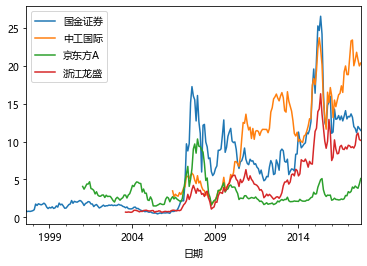

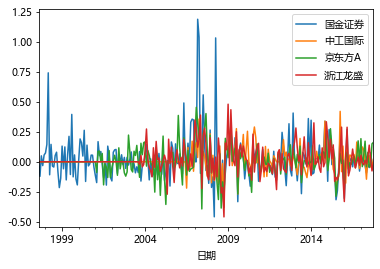

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置  
plt.rcParams['axes.unicode_minus'] = False  


def calc_returns(closes,freq="W-FRI",tye="simple"):    
    returndaily=np.log(closes).diff()
    returns=returndaily.resample(freq).sum() 
    if tye=="simple":
        return np.exp(returns)-1
    elif tye=="log":
        return returns
    
%cd  D:\teaching\金融数据分析datafin\portfolio
filenames=["002051.SZ.CSV","000725.SZ.CSV","600352.SH.CSV"]
dailydata=pd.read_csv("600109.SH.csv",encoding="gbk",index_col=2,parse_dates=True)
Dprice=dailydata["收盘价(元)"]
#Dprice.name="600109"+dailydata.iloc[1,1]
Dprice.name=dailydata.iloc[1,1]
for ff in filenames:
    dailydata=pd.read_csv(ff,encoding="gbk",index_col=2,parse_dates=True)
    close=dailydata["收盘价(元)"]
    #close.name=ff.split(".")[0]+dailydata.iloc[1,1]
    close.name=dailydata.iloc[1,1]
    Dprice=pd.concat([Dprice,close],axis=1) 
#returns=calc_returns(Dprice,"M")    

Dprice=Dprice.resample("M").last()
returns=calc_returns(Dprice,freq="M",tye="simple")

%matplotlib inline 
Dprice.plot()
returns.plot()



上面的图展示月简单收益率，可以看出，对个股来说，大的收益和大的损失还是比较多的，增长一倍，或者损失一半都是可能的。下面取07到17年的数据。

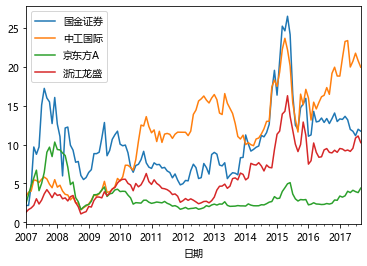

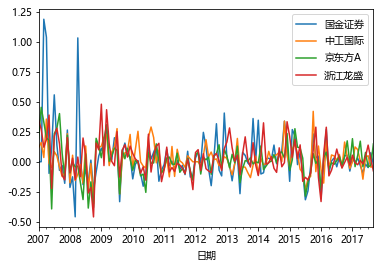

In [2]:
Dprice=Dprice["2007-1":"2017-9"]
returns=returns["2007-1":"2017-9"]
Dprice.plot()
returns.plot()


In [3]:
Dprice.tail(5)

,国金证券,中工国际,京东方A,浙江龙盛
日期,,,,
2017-05-31,11.96,19.9906,3.8307,9.1323
2017-06-30,11.72,20.7300,4.1284,9.5300
2017-07-31,11.15,21.7700,3.9500,10.8500
2017-08-31,11.98,20.8000,3.8300,11.1100
2017-09-30,11.73,19.9700,4.4000,10.2600


In [4]:
#目标函数

def objfunvar(W, Sigma):
    port_var = np.dot(np.dot(W,Sigma),W.T) 
    return np.sqrt(port_var)

def portfolio(means,Sigma,target,sellshort=True): 
    min_mean, max_mean = means.min(), means.max()    
    nstocks = len(means)
    if sellshort:
        bounds=None
    else:
        bounds = [(0,1) for i in np.arange(nstocks)]
    
    weights = np.ones(nstocks)/nstocks        
    constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1},
                      {'type': 'eq', 
                        'fun': lambda W: np.sum(W*means) -target})
    results = scopt.minimize(objfunvar, weights,Sigma, 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
    if not results.success: 
        raise Exception(results.message)
    
    std_=objfunvar(results.x,Sigma)
    weight=np.round(results.x, 5)
    return {'Means': target, 
            'risk':std_, 
            'Weights': weight}

(0.1, 0.26)

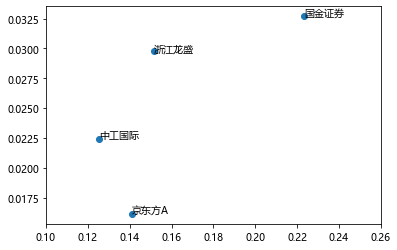

In [5]:
returnc1=returns
means=returnc1.mean()
Sigma=returnc1.cov()
stds=np.sqrt(np.diag(Sigma))
 
plt.scatter(stds,means)
for i in range(len(means)):
    plt.text(stds[i],means[i],means.index[i])
plt.xlim(0.1,0.26)

In [6]:
Sigma

,国金证券,中工国际,京东方A,浙江龙盛
国金证券,0.049869,0.011923,0.014319,0.012142
中工国际,0.011923,0.015744,0.009263,0.007933
京东方A,0.014319,0.009263,0.019878,0.013300
浙江龙盛,0.012142,0.007933,0.013300,0.022979


In [7]:
means

国金证券    0.032690
中工国际    0.022440
京东方A    0.016129
浙江龙盛    0.029751
dtype: float64

{'Means': 0.026, 'risk': 0.11503107174679358, 'Weights': array([0.07179, 0.54191, 0.     , 0.38629])}


(0.1, 0.26)

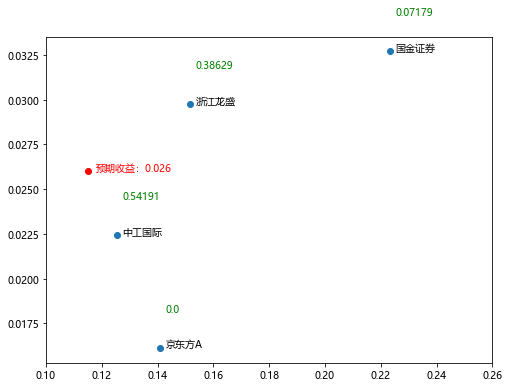

In [8]:
#0.02
target=0.026
portf=portfolio(means,Sigma,target,sellshort=False)
print(portf)
fig=plt.figure(figsize=(8,6))
plt.scatter(stds,means)
for i in range(len(means)):
    plt.text(stds[i]+0.002,means[i],means.index[i])
    plt.text(stds[i]+0.002,means[i]+0.002,portf["Weights"][i],color="green")

    

#画出投资组合
plt.scatter(portf["risk"],portf["Means"],c="red")
plt.text(portf["risk"]+0.003,portf["Means"],"预期收益："+str(target),color="red")
plt.xlim(0.1,0.26)


+ **预期收益率从0.026到0.027**

(0.1, 0.3)

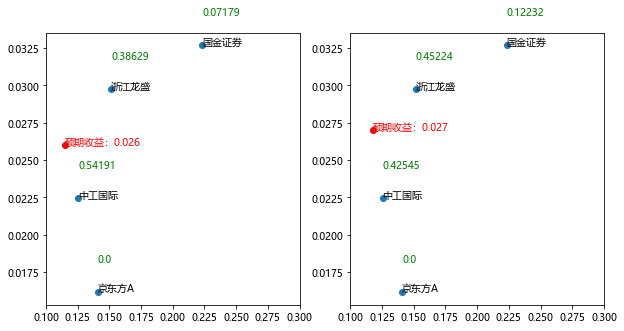

In [9]:
Dprice1=Dprice["2007-1":"2011-12"]
returns1=returns["2007-1":"2011-12"]
 
return1=returns
means=return1.mean()
Sigma=return1.cov()
stds=np.sqrt(np.diag(Sigma))
  
plt.figure(figsize=(10, 5))
plt.subplot(121)    
target=0.026
portf=portfolio(means,Sigma,target,sellshort=False)


plt.scatter(stds,means)
for i in range(len(means)):
    plt.text(stds[i],means[i],means.index[i])
    plt.text(stds[i],means[i]+0.002,portf["Weights"][i],color="green")


#画出投资组合
plt.scatter(portf["risk"],portf["Means"],c="red")
plt.text(portf["risk"],portf["Means"],"预期收益："+str(target),color="red")


plt.xlim(0.1, 0.3)
 

plt.subplot(122)
target=0.027
portf=portfolio(means,Sigma,target,sellshort=False)


plt.scatter(stds,means)
for i in range(len(means)):
    plt.text(stds[i],means[i],means.index[i])
    plt.text(stds[i],means[i]+0.002,portf["Weights"][i],color="green")


#画出投资组合
plt.scatter(portf["risk"],portf["Means"],c="red")
plt.text(portf["risk"],portf["Means"],"预期收益："+str(target),color="red")
plt.xlim(0.1, 0.3)
 

可以看出，收益率变化0.001,中工国际的持股就从0.54变化到0.42,减持超过10%以上。 可以画出更详细的变化图。

+ 如果其中某个资产的收益率发生了变化，投资组合是否变化是否剧烈。中工国际的月收益率从0.022440改到0.03,看看组合的变化。

In [10]:
means=return1.mean()
means1=means.copy()
means1[1]=0.03
means,means1

(国金证券    0.032690
 中工国际    0.022440
 京东方A    0.016129
 浙江龙盛    0.029751
 dtype: float64,
 国金证券    0.032690
 中工国际    0.030000
 京东方A    0.016129
 浙江龙盛    0.029751
 dtype: float64)

In [11]:
portf1=portfolio(means,Sigma,target,sellshort=False)
portf2=portfolio(means1,Sigma,target,sellshort=False)
print(portf1)
print(portf2)

{'Means': 0.027, 'risk': 0.11803531430267879, 'Weights': array([0.12232, 0.42545, 0.     , 0.45224])}
{'Means': 0.027, 'risk': 0.11196243539595394, 'Weights': array([0.00192, 0.55456, 0.21251, 0.23101])}


##  投资组合



## 风险平价模型

+ 调整各类资产的权重以实现组合中各类资产的风险贡献（Risk Contribution）基本均衡。风险贡献可以理解为组合的损失贡献（Loss Contribution），即各类资产的损失占组合损失的部分是相对均衡的。



| 类别  | 股票 |  债券  
|---- | ---- | ---- 
|年化收益率  | 7.8% | 3.9% 
|年化波动率 | 26.62% | 2.66% 


如果配置10%的股票，90%的债券。

股票波动率对资产组合波动率的影响，

$$0.1\times 0.2662=0.027$$

债券波动率对资产组合波动率的影响，

$$0.9\times 0.0266=0.024$$

+ 具体操作可能并非对每一个资产进行风险分配，可能对经济环境、风险因子进行分配。

### Black-Litterman 模型

+ 20世纪90年代在高盛公司的两个研究员Black和Litterman提出了一个基于   
Markowitz模型的改进模型，  简称B-L模型，他们的模型特点是导入了  
投资者对某项资产的主观预期，使得根据市场历史数据计 算预期收益率和  
投资者的看法结合在一起，形成一个新的市场收益预期，从而使得优化结果  
更加稳定和准确。

+ 在B-L模型下，投资者对市场看法的表达比较灵活。  
投资者在表达自己的看法时，也可以加入自己的置信度。

## 主动投资组合

预测。